# Face generator GAN

In [114]:
import zipfile
import random

import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms
from torchsummary import summary

In [115]:
data_path = './data'
img_size = 64
batch_size = 32
latent_size = 100
img_channels = 3
num_channels = 8
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-5
num_epochs = 3
discriminator_iterations = 1
generator_iterations = 1

In [116]:
# with zipfile.ZipFile('path/to/zip', 'r') as zip_ref:
#     zip_ref.extractall('path/to/extract/folder')

In [117]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Dataset size = {len(dataset)}')
print(f'Batch shape = {next(iter(dataloader))[0].shape}')

Dataset size = 202599
Batch shape = torch.Size([32, 3, 64, 64])


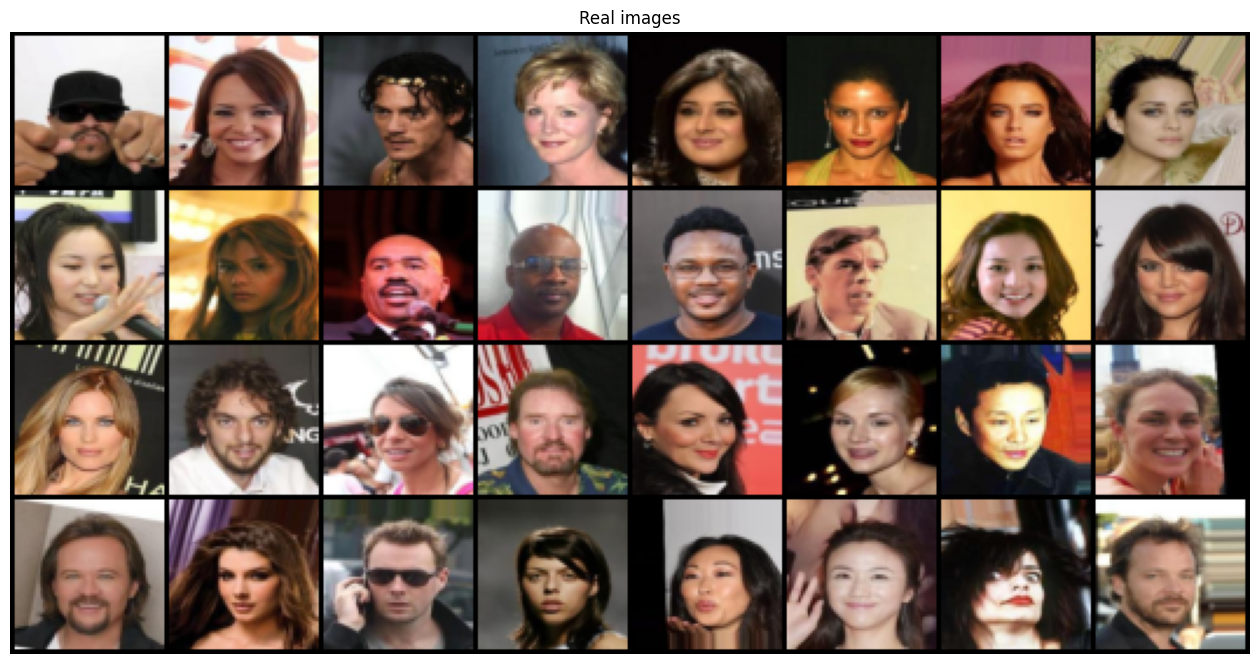

In [118]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(16, 16))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Real images')
    plt.show()

images, _ = next(iter(dataloader))
imshow(torchvision.utils.make_grid(images))

In [119]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, num_channels):
        super(Discriminator, self).__init__()
        self.img_channels = img_channels
        self.num_channels = num_channels

        self.net = nn.Sequential(
            nn.Conv2d(img_channels, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, 2*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2*num_channels, 4*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(4*num_channels, 8*num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8*num_channels, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x.view(-1, 1)

In [120]:
class Generator(nn.Module):
    def __init__(self, latent_size, num_channels, img_channels):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.num_channels = num_channels
        self.img_channels = img_channels

        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 8*num_channels, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(8*num_channels, 4*num_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(4*num_channels, 2*num_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(2*num_channels, num_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(num_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.net(x)
        return x


In [121]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [122]:
discriminator = Discriminator(img_channels, num_channels).to(device)
discriminator.apply(weights_init)
summary(discriminator, (img_channels, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 8, 32, 32]           384
|    └─LeakyReLU: 2-2                    [-1, 8, 32, 32]           --
|    └─Conv2d: 2-3                       [-1, 16, 16, 16]          2,048
|    └─LeakyReLU: 2-4                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-5                       [-1, 32, 8, 8]            8,192
|    └─LeakyReLU: 2-6                    [-1, 32, 8, 8]            --
|    └─Conv2d: 2-7                       [-1, 64, 4, 4]            32,768
|    └─LeakyReLU: 2-8                    [-1, 64, 4, 4]            --
|    └─Conv2d: 2-9                       [-1, 1, 1, 1]             1,024
|    └─Sigmoid: 2-10                     [-1, 1, 1, 1]             --
Total params: 44,416
Trainable params: 44,416
Non-trainable params: 0
Total mult-adds (M): 2.01
Input size (MB): 0.05
Forward/backward pass s

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 8, 32, 32]           384
|    └─LeakyReLU: 2-2                    [-1, 8, 32, 32]           --
|    └─Conv2d: 2-3                       [-1, 16, 16, 16]          2,048
|    └─LeakyReLU: 2-4                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-5                       [-1, 32, 8, 8]            8,192
|    └─LeakyReLU: 2-6                    [-1, 32, 8, 8]            --
|    └─Conv2d: 2-7                       [-1, 64, 4, 4]            32,768
|    └─LeakyReLU: 2-8                    [-1, 64, 4, 4]            --
|    └─Conv2d: 2-9                       [-1, 1, 1, 1]             1,024
|    └─Sigmoid: 2-10                     [-1, 1, 1, 1]             --
Total params: 44,416
Trainable params: 44,416
Non-trainable params: 0
Total mult-adds (M): 2.01
Input size (MB): 0.05
Forward/backward pass s

In [123]:
generator = Generator(latent_size, num_channels, img_channels).to(device)
generator.apply(weights_init)
summary(generator, (latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 64, 4, 4]            102,400
|    └─LeakyReLU: 2-2                    [-1, 64, 4, 4]            --
|    └─ConvTranspose2d: 2-3              [-1, 32, 8, 8]            32,768
|    └─LeakyReLU: 2-4                    [-1, 32, 8, 8]            --
|    └─ConvTranspose2d: 2-5              [-1, 16, 16, 16]          8,192
|    └─LeakyReLU: 2-6                    [-1, 16, 16, 16]          --
|    └─ConvTranspose2d: 2-7              [-1, 8, 32, 32]           2,048
|    └─LeakyReLU: 2-8                    [-1, 8, 32, 32]           --
|    └─ConvTranspose2d: 2-9              [-1, 3, 64, 64]           384
|    └─Tanh: 2-10                        [-1, 3, 64, 64]           --
Total params: 145,792
Trainable params: 145,792
Non-trainable params: 0
Total mult-adds (M): 9.65
Input size (MB): 0.00
Forward/backward pa

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 64, 4, 4]            102,400
|    └─LeakyReLU: 2-2                    [-1, 64, 4, 4]            --
|    └─ConvTranspose2d: 2-3              [-1, 32, 8, 8]            32,768
|    └─LeakyReLU: 2-4                    [-1, 32, 8, 8]            --
|    └─ConvTranspose2d: 2-5              [-1, 16, 16, 16]          8,192
|    └─LeakyReLU: 2-6                    [-1, 16, 16, 16]          --
|    └─ConvTranspose2d: 2-7              [-1, 8, 32, 32]           2,048
|    └─LeakyReLU: 2-8                    [-1, 8, 32, 32]           --
|    └─ConvTranspose2d: 2-9              [-1, 3, 64, 64]           384
|    └─Tanh: 2-10                        [-1, 3, 64, 64]           --
Total params: 145,792
Trainable params: 145,792
Non-trainable params: 0
Total mult-adds (M): 9.65
Input size (MB): 0.00
Forward/backward pa

In [124]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

opt_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [125]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        opt_discriminator.step()

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        opt_generator.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = generator(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/3][0/6332]	Loss_D: 1.3866	Loss_G: 0.6931	D(x): 0.4998	D(G(z)): 0.5000 / 0.5000


KeyboardInterrupt: 